In [64]:
import pandas as pd
import numpy as np
import unicodedata
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [65]:
################################
##### Merging two datasets #####
################################


df1 = pd.read_csv("fake_job_postings.csv", na_values="<NA>", index_col=False)
df1.drop(['benefits', 'company_profile', 'employment_type', 'salary_range',
          'industry', 'department', 'required_experience', 'required_education', 'job_id', 'function',], axis=1, inplace=True)
df2 = pd.read_csv("job_train.csv", na_values="<NA>", index_col=False)
df2 = df2[df2['fraudulent']==1]
merged_df = pd.concat([df1, df2])
merged_df = merged_df.reset_index(drop=True)
merged_df = merged_df.fillna(pd.NA)
# merged_df.to_csv("final_data.csv")
merged_df.head()

,title,location,description,requirements,telecommuting,has_company_logo,has_questions,fraudulent
0,Marketing Intern,"US, NY, New York","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,0,1,0,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,0,1,0,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever","Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,0,1,0,0
3,Account Executive - Washington DC,"US, DC, Washington",THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",0,1,0,0
4,Bill Review Manager,"US, FL, Fort Worth",JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,0,1,1,0


In [67]:
############################
##### Define Functions #####
############################

def remove_accents(text):
    if pd.isna(text):
        return text
    # Normalize to NFD (decompose accented chars), then filter out combining marks
    return ''.join(c for c in unicodedata.normalize('NFD', str(text))
                   if unicodedata.category(c) != 'Mn')

def clean_accents(column, print_change):
    cleaned_lst = []
    for val in merged_df[column]:
        if not pd.isna(val) and str(val).strip() != "": 
            cleaned_val = remove_accents(val)
            if val != cleaned_val:
                cleaned_lst.append((val, cleaned_val))
    cleaned_lst = list(set(cleaned_lst))
    if print_change:
        for cleaned in cleaned_lst:
            print(cleaned)

def has_non_latin(text):
    if pd.isna(text):
        return 0
    for char in text:
        if ord(char) > 127:
            return 1
    return 0

def remove_non_latin(text):
    if pd.isna(text):
        return pd.NA
    cleaned_text = ""
    for char in text:
        if ord(char) > 127:
            continue
        cleaned_text += char
    return cleaned_text

In [68]:
###########################
##### Data Processing #####
###########################

# drop rows with missing description (18336 --> 18334 samples)
merged_df = merged_df.dropna(subset=['description'])

### Text Columns ###

# convert accents to basic latin
text_cols = ['location', 'description', 'requirements']
for col in text_cols:
    clean_accents(col, False)

# mask and remove non-basic-latin
for col in text_cols:
    merged_df[f"{col}_has_non_latin"] = merged_df[col].apply(has_non_latin)
    merged_df[col] = merged_df[col].apply(remove_non_latin)

# Make new feature that has binary value for whether requirements was missing or not
merged_df["has_requirements"] = merged_df["requirements"].notna()
# Merge description with requirements so they are in one new feature - called description_and_requirements
merged_df["description_and_requirements"] = merged_df["description"] + merged_df["requirements"].fillna("")

### LOCATION ###

# Extract country and state
pattern1 = r'(^[A-Z]{2},\s*[A-Z0-9]{1,3})'
merged_df['country_state'] = merged_df['location'].str.extract(pattern1, expand=False)
# Extract country
pattern2 = r'(^[A-Z]{2})'
merged_df['country'] = merged_df['location'].str.extract(pattern2, expand=False)
# Manage Remote jobs
merged_df['is_remote'] = merged_df['location'].str.lower().str.contains('remote|work from home', na=False) & merged_df['country_state'].isna()
merged_df.loc[merged_df['is_remote'], 'country_state'] = "Remote"
merged_df.loc[merged_df['is_remote'], 'country'] = "Remote"
merged_df.drop(columns=["is_remote"], inplace=True)

# New column - location mask
merged_df["has_location"] = merged_df["location"].notna()
# New column - detailed location mask - something beyond just the country code
merged_df["has_location_details"] = (merged_df["location"].str.lower().str.strip() == merged_df["country"].str.lower().str.strip()).fillna(False)

merged_df.head()

/var/folders/pt/l_98qj6n6kj9mwv6z_qvzr600000gn/T/ipykernel_79314/1828964754.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df[f"{col}_has_non_latin"] = merged_df[col].apply(has_non_latin)
/var/folders/pt/l_98qj6n6kj9mwv6z_qvzr600000gn/T/ipykernel_79314/1828964754.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df[col] = merged_df[col].apply(remove_non_latin)
/var/folders/pt/l_98qj6n6kj9mwv6z_qvzr600000gn/T/ipykernel_79314/1828964754.py:17: SettingWithCopyWarning: 
A value is trying 

,title,location,description,requirements,telecommuting,has_company_logo,has_questions,fraudulent,location_has_non_latin,description_has_non_latin,requirements_has_non_latin,has_requirements,description_and_requirements,country_state,country,has_location,has_location_details
0,Marketing Intern,"US, NY, New York","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,0,1,0,0,0,0,0,True,"Food52, a fast-growing, James Beard Award-winn...","US, NY",US,True,False
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,0,1,0,0,0,1,1,True,Organised - Focused - Vibrant - Awesome!Do you...,NaN,NZ,True,False
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever","Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,0,1,0,0,0,0,1,True,"Our client, located in Houston, is actively se...","US, IA",US,True,False
3,Account Executive - Washington DC,"US, DC, Washington",THE COMPANY: ESRI Environmental Systems Resea...,"EDUCATION:Bachelors or Masters in GIS, busines...",0,1,0,0,0,1,1,True,THE COMPANY: ESRI Environmental Systems Resea...,"US, DC",US,True,False
4,Bill Review Manager,"US, FL, Fort Worth",JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,0,1,1,0,0,1,1,True,JOB TITLE: Itemization Review ManagerLOCATION:...,"US, FL",US,True,False


In [69]:
# merged_df.to_csv("final_data.csv")

In [70]:
# make a mapping from 2-letter abbreviations to full country names
iso_df = pd.read_csv("ISO3166.csv")
iso_series = pd.Series(iso_df["name"].apply(remove_accents).values, index=iso_df["alpha-2"].values)     # remove accents

# data cleaning
countries_with_comma = iso_series[iso_series.apply(lambda x: ',' in x)].index
print(f"There are some {len(iso_series[countries_with_comma])} country names with commas")
display(iso_series[countries_with_comma].head())

iso_series = iso_series.apply(lambda x: x.split(',')[0] if ',' in x else x)                             # get the 'main' name

print(f'The commas are cleaned now, as shown below')
display(iso_series[countries_with_comma].head())

iso_series = iso_series[iso_series.index.isin(merged_df["country"].to_list())]                          # save only the existing ones
iso_dict = iso_series.to_dict()                                                                         # conver to dict
print('Finally, ISO code to country name mapping looks like this')
display(iso_series.head())

# there must be no overlapping in both keys and values (so there can be a valid inverse mapping)
print(f'Sanity check for the inverse mapping: {
    len(set(iso_dict.keys())) == len(set(iso_dict.values()))
}')
country_dict = {country: code for country, code in zip(iso_dict.values(), iso_dict.keys())}

# manual updates
country_dict.update({
    'USA': 'US',
    'United States': 'US',

    'UK': 'GB',
    'United Kingdom': 'GB',
    'Great Britain': 'GB',
    'Ireland': 'GB',
    'Scottland': 'GB',
    'Wales': 'GB',
    'England': 'GB',

    'Vietnam': 'VN',

    'Russia': 'RU',
    
    'South Korea': 'KP',
    
    'Korea': 'KP'
})

There are some 14 country names with commas


BO           Bolivia, Plurinational State of
BQ          Bonaire, Sint Eustatius and Saba
CD         Congo, Democratic Republic of the
IR                 Iran, Islamic Republic of
KP    Korea, Democratic People's Republic of
dtype: object

The commas are cleaned now, as shown below


BO    Bolivia
BQ    Bonaire
CD      Congo
IR       Iran
KP      Korea
dtype: object

Finally, ISO code to country name mapping looks like this


AL      Albania
AR    Argentina
AM      Armenia
AU    Australia
AT      Austria
dtype: object

Sanity check for the inverse mapping: True


In [71]:

escaped_country = [re.escape(c) for c in country_dict.keys()]
pattern_country = r'\b(' + '|'.join(escaped_country) + r')\b'

print(f'Sneak peek to the compiled regex pattern')
display(pattern_country[:100])

def find_location(text):
    if not text:
        return None
    match = re.search(pattern_country, text, re.IGNORECASE) # case insensitive search
    if match:
        return match.group(0)
    return None

missing_country = merged_df[merged_df['country'].isna()].index          # index of rows missing country
df_extracted_country = merged_df.loc[missing_country, 'description_and_requirements'].apply(find_location).dropna()
print(f'Among {len(missing_country)} rows missing country, extracted countries for {len(df_extracted_country)} rows')
display(df_extracted_country.head())

merged_df.loc[df_extracted_country.index, 'country'] = df_extracted_country.apply(lambda x: country_dict[x])                # retrieve the country codes
print(f'Result in only {len(merged_df[merged_df['country'].isna()])} rows of missing countries (vs. {len(missing_country)} rows originally)')

Sneak peek to the compiled regex pattern


'\\b(Albania|Argentina|Armenia|Australia|Austria|Bahrain|Bangladesh|Belarus|Belgium|Brazil|Bulgaria|Ca'

Among 354 rows missing country, extracted countries for 53 rows


749         UK
1952    Greece
1993    Canada
2202     Spain
2687     Kenya
Name: description_and_requirements, dtype: object

Result in only 301 rows of missing countries (vs. 354 rows originally)


<Axes: >

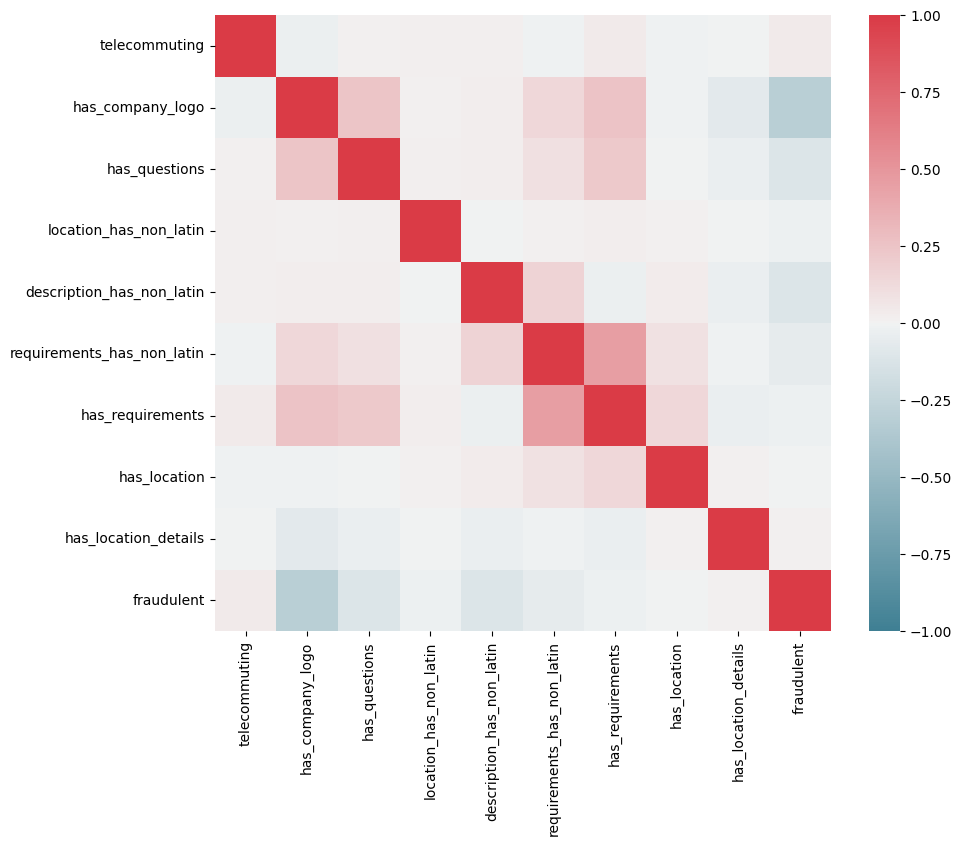

In [ ]:
#################################################
##### Feature Correlations (binary features #####
#################################################

cols = ['telecommuting', 'has_company_logo', 'has_questions', 'location_has_non_latin',
'description_has_non_latin', 'requirements_has_non_latin', 'has_requirements',
'has_location', 'has_location_details', 'fraudulent']
f, ax = plt.subplots(figsize=(10, 8))
corr = merged_df[cols].corr(method='pearson')
sns.heatmap(corr,
            mask=np.zeros_like(corr, dtype=np.bool),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True,
            ax=ax,
            vmin=-1, 
            vmax=1,
            center=0)

In [7]:
# filling in missing country_state
display(len(merged_df[merged_df['country_state'].isna()]))

missing_country_state = merged_df.loc[(merged_df['country_state'].isna())].index
merged_df.loc[missing_country_state, 'country_state'] = merged_df.loc[missing_country_state, 'country'].dropna().apply(lambda x: f'{x}, NO_STATE' if x else float('nan'))
display(len(merged_df[merged_df['country_state'].isna()]))

merged_df.to_csv("final_data.csv")

2599

301

# Note

In [8]:
n_fraudulent_missing_cs = len(merged_df.loc[(merged_df['country_state'].isna()) & (merged_df['fraudulent'] == 1)])
n_missing_cs = len(merged_df.loc[(merged_df['country_state'].isna())])

display((n_fraudulent_missing_cs, n_missing_cs))
print(f'Among the samples missing country_state, {n_fraudulent_missing_cs/n_missing_cs*100:.3f}% of fradulent samples will be discarded')

(26, 301)

Among the samples missing country_state, 8.638% of fradulent samples will be discarded
